##Description:

 Code for RhizCG microbial community analysis to be presented at ESA, August 12th, 2015



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [2]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R

library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)



foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parR

In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [6]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 44K
lrwxrwxrwx 1 bryan bryan  130 Aug 11 15:24 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan  143 Aug 11 15:24 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 3.8K Aug 11 15:11 facet_NMDS_w-enz.pdf
-rw-rw-r-- 1 bryan bryan 7.4K Aug 11 11:18 NMDS_full_wunif.pdf
-rw-rw-r-- 1 bryan bryan  22K Jul 27 13:53 heatmap_rank2.pdf


# Loading/editting OTU table

In [7]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

#apply gsub across columns to replace ___ w/ "", reload to phyloseq object
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

In [8]:
%%R
colnames(plantData)

Error in colnames(plantData) : 
  error in evaluating the argument 'x' in selecting a method for function 'colnames': Error: object 'plantData' not found


In [9]:
%%R
plantData = read.table('/home/bryan/RhizCG/data/MiSeq_amplicon/PlotData.txt', header = TRUE)

s = sample_data(physeq)
PD = plantData[,c(1,18, 20, 23,27, 29, 31:55)]
s2 = left_join(s, PD, by = c("X.sample" = "Unique"))
rownames(s2) = s2$X.sample
sample_data(physeq) = s2
sample_data(physeq) %>% head

Sample Data:        [6 samples by 51 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample2-1.06_Npos sample2-1.06_Npos       1            1             H9
sample6-4.27_Npos sample6-4.27_Npos       1            2            F11
sample4-4.27_Nneg sample4-4.27_Nneg       1            1            B12
sample4-1.06_Nneg sample4-1.06_Nneg       1            1            E11
sample2-1.06_Nneg sample2-1.06_Nneg       1            1             G9
sample6-3.07_Nneg sample6-3.07_Nneg       1            2            C11
                  primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
sample2-1.06_Npos                  72                72         72 1.06_Npos
sample6-4.27_Npos                  86               182        182 4.27_Npos
sample4-4.27_Nneg                  90                90         90 4.27_Nneg
sample4-1.06_Nneg                  85                85         85 1.06_Nneg
sample2-1.06_Nneg                  71                71

In [10]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))
#set DAP to factor
#sample_data(physeq)$DAP = factor(sample_data(physeq)$DAP)
print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 51 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


##Normalize samples and filter out taxa that are less than .1*length(x)

In [11]:
%%R 
# filtering/normalizing
physeq.snorm = prune_samples(sample_sums(physeq) >= 10, physeq)
physeq.snorm = transform_sample_counts(physeq.snorm, function(x) x/sum(x))
  
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (0.1 * length(x)), TRUE)
print(physeq.snorm)
#physeq.thresh = physeq.snorm

print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 51 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6736 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 51 sample variables ]
tax_table()   Taxonomy Table:    [ 6736 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6736 tips and 6735 internal nodes ]


Notes: Threshold of 0.0001*length(x) removes 9 taxa, 0.01*length(x) results in 10493 taxa, 0.1*length results in 6736 taxa

## Calculate pairwise weighted Unifrac distances between samples

In [12]:
%%R
registerDoParallel(cores=28)
full.wunif.dist = phyloseq::distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [13]:
%%R
registerDoParallel(cores=28)
full.bray.dist = phyloseq::distance(physeq.thresh, 
                      method = "bray", 
                      parallel = TRUE, 
                      normalized = FALSE)

# NMDS of w-unif

Run 0 stress 0.1403636 
Run 1 stress 0.1556445 
Run 2 stress 0.1686085 
Run 3 stress 0.141928 
Run 4 stress 0.1541218 
Run 5 stress 0.1711705 
Run 6 stress 0.1728781 
Run 7 stress 0.1427792 
Run 8 stress 0.140617 
... procrustes: rmse 0.006471559  max resid 0.09743099 
Run 9 stress 0.1458774 
Run 10 stress 0.1403466 
... New best solution
... procrustes: rmse 0.002055413  max resid 0.02173507 
Run 11 stress 0.1554935 
Run 12 stress 0.1427835 
Run 13 stress 0.1559746 
Run 14 stress 0.1842612 
Run 15 stress 0.1524 
Run 16 stress 0.1552237 
Run 17 stress 0.1673153 
Run 18 stress 0.1403669 
... procrustes: rmse 0.002154593  max resid 0.023773 
Run 19 stress 0.1653331 
Run 20 stress 0.1416902 
Saving 8.33 x 4.86 in image


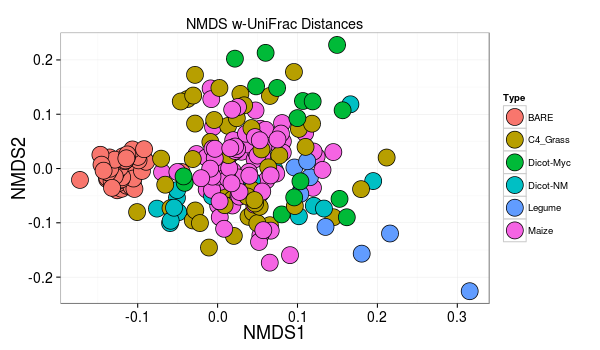

In [14]:
%%R -w 600 -h 350

nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = full.wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Type), pch = 21, size = 8) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18)) +
        labs(title = "NMDS w-UniFrac Distances", size = 20)
        #scale_size(range=c(2,8))

##need arrange into a presentation quality graphic and save

grid.arrange(p1, ncol=1)
ggsave(filename = "NMDS_full_wunif.pdf", plot = p1)

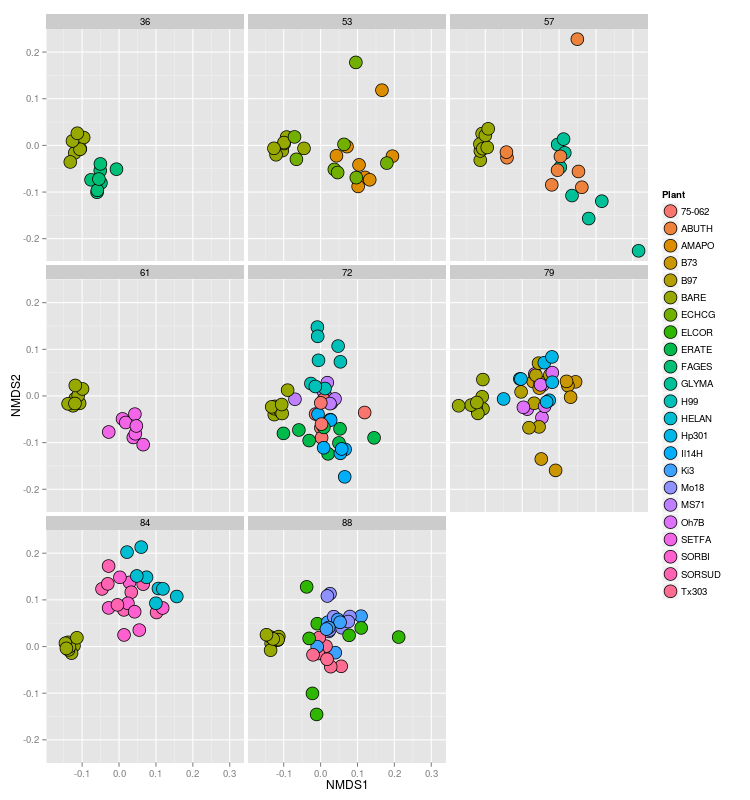

In [15]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1

##Subset just plants to evaluate variation without bare soil

In [16]:
%%R

physeq.plant = subset_samples(physeq.thresh, Plant != "BARE")
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6736 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 51 sample variables ]
tax_table()   Taxonomy Table:    [ 6736 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6736 tips and 6735 internal nodes ]


In [29]:
%%R
#create maize/non-maize variable
sample_data(physeq.plant)$Maize = ifelse(sample_data(physeq.plant)$Type == "Maize", "Maize", 
                                         "Annuals")
sample_data(physeq.plant)$Maize = factor(sample_data(physeq.plant)$Maize)

In [30]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = phyloseq::distance(physeq.plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [31]:
%%R
registerDoParallel(cores=28)
plant.bray.dist = phyloseq::distance(physeq.plant, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#NMDS of plant only w-UNIF

In [70]:
%%R -w 800 -h 350


nmds = ordinate(physeq.plant, 
                method = "NMDS", 
               distance = plant.wunif.dist)

p = plot_ordination(physeq.plant, nmds, justDF = TRUE)
str(p)

Run 0 stress 0.1714023 
Run 1 stress 0.1837728 
Run 2 stress 0.1808432 
Run 3 stress 0.1822545 
Run 4 stress 0.1905541 
Run 5 stress 0.1838762 
Run 6 stress 0.1861131 
Run 7 stress 0.1895069 
Run 8 stress 0.1831758 
Run 9 stress 0.1921013 
Run 10 stress 0.1860301 
Run 11 stress 0.1876759 
Run 12 stress 0.1764647 
Run 13 stress 0.1807812 
Run 14 stress 0.180503 
Run 15 stress 0.2109168 
Run 16 stress 0.1934203 
Run 17 stress 0.1827004 
Run 18 stress 0.1878505 
Run 19 stress 0.2042151 
Run 20 stress 0.1916546 
'data.frame':	176 obs. of  54 variables:
 $ NMDS1              : num  -0.0625 -0.02578 -0.07699 -0.00435 -0.01404 ...
 $ NMDS2              : num  -0.046 -0.0235 -0.0422 -0.0226 -0.0113 ...
 $ X.sample           : chr  "sample5-1.22_Nneg" "sample6-4.12_Npos" "sample4-1.03_Npos" "sample5-2.06_Npos" ...
 $ Library            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Primer_Plate       : int  1 2 1 2 2 1 1 1 1 2 ...
 $ Primer_Well_ID     : Factor w/ 93 levels "A1","A10","A11",..: 7 87 18 37 8

In [36]:
%%R
#keepvariables = sample_data(physeq.plant)[,c(34:37,43)]
plantsd = data.frame(sample_data(physeq.plant))
colnames(plantsd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Biomass_P"           "SLA"                 "LeafC_N"            
[25] "Plant_CN"            "tN_p"                "BX_rel"             
[28] "CB_rel"              "LAP_rel"             "NAG_rel"            
[31] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[34] "NAG_activity_g"      "BX_bare_factor"      "CB_bare_factor"     
[37] "LAP_bare_factor"     "NAG_bare_factor"     "BX_dif"             
[40] "CB_dif"              "LAP_dif"             "NAG_dif"            
[43] "

In [69]:
%%R -w 650 -h 450
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21, size = 6) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18),
             strip.text = element_text(size=25)) +
        facet_wrap(~Maize) +
        labs(title = "NMDS w-UniFrac Distances", size = 20) +
        theme(legend.title = element_text(colour = 'black', angle = 0, size = 18, 
                                          hjust = 3, vjust = 7, face = 'bold')) +
        theme(legend.text = element_text(size = 10))
        #title.theme = element_text(size = 12, face = "bold") 
p1
ggsave(filename = "NMDS_plant_wunif.pdf", plot = p1)

Saving 9.03 x 6.25 in image


##Now overlay enzyme data

In [124]:
%%R
#keepvariables = sample_data(physeq.plant)[,c(34:37,43)]
plantsd = data.frame(sample_data(physeq.plant))
colnames(plantsd)
plantenz = plantsd[,31:34]


In [130]:
%%R
drop_out = plantenz$NAG_activity_g <40

penz_d = plantenz[drop_out,]
cor(penz_d)


               BX_activity_g CB_activity_g LAP_activity_g NAG_activity_g
BX_activity_g      1.0000000    0.88867092     0.16916439     0.45115133
CB_activity_g      0.8886709    1.00000000     0.04873245     0.41276081
LAP_activity_g     0.1691644    0.04873245     1.00000000     0.01272968
NAG_activity_g     0.4511513    0.41276081     0.01272968     1.00000000



***VECTORS

           NMDS1    NMDS2     r2 Pr(>r)  
BX_dif  -0.83833 -0.54517 0.0329  0.055 .
CB_dif  -0.83221 -0.55446 0.0114  0.382  
LAP_dif  0.99985 -0.01713 0.0311  0.053 .
NAG_dif -0.63383  0.77348 0.0062  0.610  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999


              NMDS1        NMDS2 var
BX_dif  -0.15198828 -0.098839231  BX
CB_dif  -0.08866312 -0.059071598  CB
LAP_dif  0.17622086 -0.003018649 LAP
NAG_dif -0.05009747  0.061135415 NAG


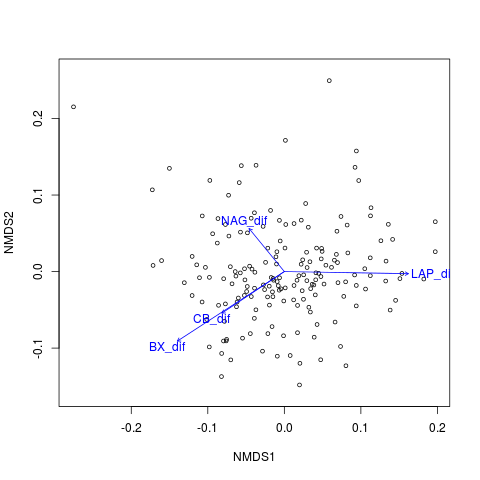

In [131]:
%%R
#ord.fit = envfit(nmds ~ BX_activity_g + CB_activity_g + LAP_activity_g + NAG_activity_g, plantsd)
ord.fit = envfit(nmds ~ BX_dif + CB_dif + LAP_dif + NAG_dif, plantsd)
sol = nmds
NMDS = data.frame(MDS1 = sol$points[,1], MDS2 = sol$points[,2])
#plot(nmds)
#plot(ord.fit)
ord.fit %>% print
enz_scores = data.frame(scores(ord.fit, "vectors")) 
enz_scores$var = c("BX", "CB", "LAP", "NAG")
enz_scores %>% print
plot(nmds)
plot(ord.fit)

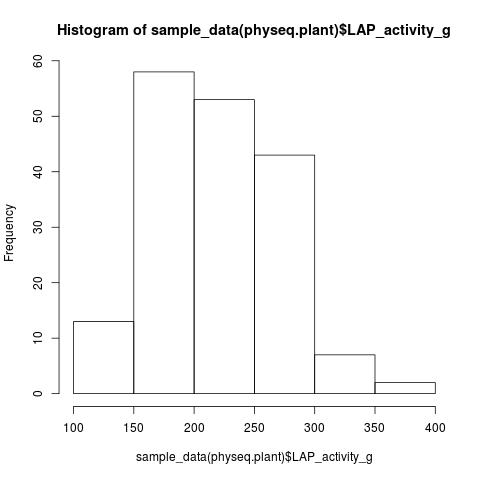

In [113]:
%%R
hist(sample_data(physeq.plant)$LAP_activity_g)


In [143]:
%%R -w 650 -h 450


# generating plot with enzyme activity of LAP as coloring 
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(color=LAP_dif), size = 7, pch=21)+
        geom_point(size = 5, pch = 21, aes(fill = LAP_activity_g)) +
        scale_fill_gradient2(name = "LAP Activity", limits=c(100,400), low = "blue", high = "red", midpoint = 200) + #, low = "red", high = "white")+
    #geom_segment(data=enz_scores,aes(x=0,xend=NMDS1,y=0,yend=NMDS2),
     # arrow = arrow(length = unit(0.5, "cm")),colour="grey",inherit_aes=FALSE)+
        #geom_text(data=enz_scores,aes(x=NMDS1,y=NMDS2,label=var),size=5) +
        facet_wrap(~Maize) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18),
             strip.text = element_text(size=25)) +
        theme(legend.title = element_text(colour = 'black', angle = 0, size = 18, 
                                          hjust = 3, vjust = 7, face = 'bold')) +
        theme(legend.text = element_text(size = 8)) +
        theme(legend.key.size = unit(1, "cm"))+
        labs(title = "nMDS w-UniFrac Distances", size = 20)

p1
ggsave(filename = "facet_NMDS_w-enz.pdf", plot = p1)

Saving 9.03 x 6.25 in image


##Phyloseq bi-plot test on bray curtis distance

Run 0 stress 0.2468198 
Run 1 stress 0.254221 
Run 2 stress 0.2528849 
Run 3 stress 0.2551624 
Run 4 stress 0.2423759 
... New best solution
... procrustes: rmse 0.0345097  max resid 0.1912311 
Run 5 stress 0.2555467 
Run 6 stress 0.2426757 
... procrustes: rmse 0.02770875  max resid 0.1832236 
Run 7 stress 0.2433851 
Run 8 stress 0.2537691 
Run 9 stress 0.2461909 
Run 10 stress 0.2514188 
Run 11 stress 0.2498875 
Run 12 stress 0.2442724 
Run 13 stress 0.2423359 
... New best solution
... procrustes: rmse 0.02986145  max resid 0.1935796 
Run 14 stress 0.2402938 
... New best solution
... procrustes: rmse 0.03162736  max resid 0.2805807 
Run 15 stress 0.2536374 
Run 16 stress 0.2592918 
Run 17 stress 0.2449677 
Run 18 stress 0.2647364 
Run 19 stress 0.239396 
... New best solution
... procrustes: rmse 0.03714661  max resid 0.1903337 
Run 20 stress 0.2402644 


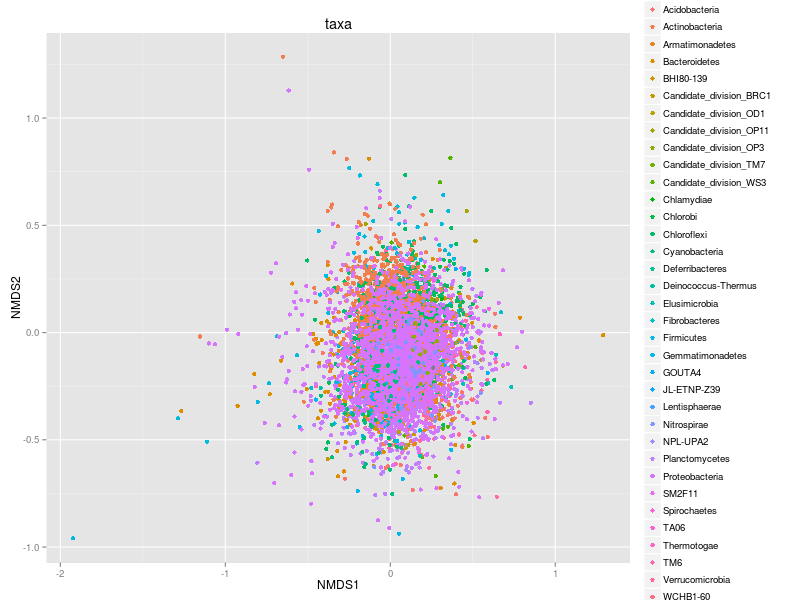

In [232]:
%%R -w 800 -h 600

pp.ord <- ordinate(physeq.plant, "NMDS", "bray")
p1 = plot_ordination(physeq.plant, pp.ord, type = "taxa", color = "Rank2", title = "taxa")
print(p1)

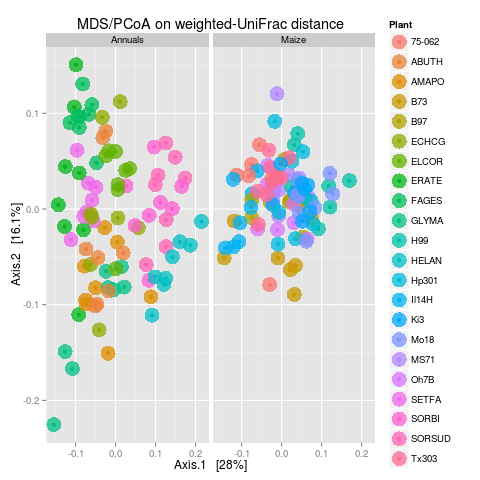

In [270]:
%%R
p = plot_ordination(physeq.plant, ordu, color = "Plant")
p = p + geom_point(size = 7, alpha = 0.75)
p = p + facet_wrap(~Maize)
p + ggtitle("MDS/PCoA on weighted-UniFrac distance")

In [273]:
%%R
ord.fit = envfit(ordu1 ~ "SLA" + "LeafC_N" + "Plant_CN" + "tN_p",  
    plantsd)
#sol = ordu

Error in terms.formula(formula, data = data) : 
  invalid model formula in ExtractVars


In [262]:
%%R
ord.fit = envfit(ordu ~ "SLA",  "LeafC_N", "Plant_CN", "tN_p",  
    plantsd)
sol = ordu
ORDU = data.frame(MDS1 = sol$points[,1], MDS2 = sol$points[,2])
#plot(nmds)
#plot(ord.fit)
ord.fit %>% print
enz_scores = data.frame(scores(ord.fit, "vectors")) 
enz_scores$var = rownames(enz_scores)
enz_scores %>% print
plot(ORDU)

Error in eval(X, data, parent.frame()) : 
  invalid 'envir' argument of type 'character'


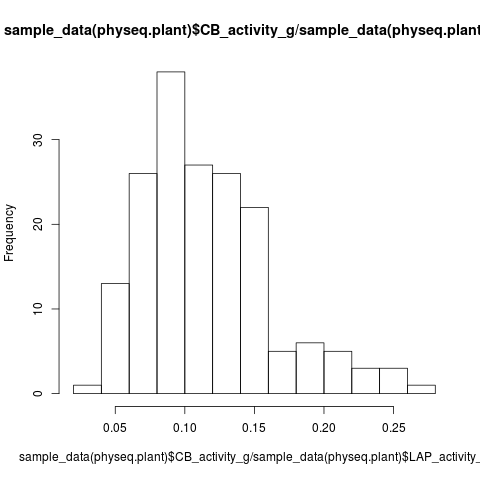

In [237]:
%%R
hist(sample_data(physeq.plant)$CB_activity_g/sample_data(physeq.plant)$LAP_activity_g, bin = .25)

#Explore relationships with enzymes and environmental variables

##Try adding enzyme vectors to plant nmds in Vegan Package

In [238]:
%%R
veganotu = function(physeq) {
    require("vegan")
    OTU = otu_table(physeq)
    if (taxa_are_rows(OTU)) {
        OTU = t(OTU)
    }
    return(as(OTU, "matrix"))
}

In [239]:
%%R
sample_data(physeq.plant) %>% colnames

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Biomass_P"           "SLA"                 "LeafC_N"            
[25] "Plant_CN"            "tN_p"                "BX_rel"             
[28] "CB_rel"              "LAP_rel"             "NAG_rel"            
[31] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[34] "NAG_activity_g"      "BX_bare_factor"      "CB_bare_factor"     
[37] "LAP_bare_factor"     "NAG_bare_factor"     "BX_dif"             
[40] "CB_dif"              "LAP_dif"             "NAG_dif"            
[43] "

                           X.sample Library Primer_Plate Primer_Well_ID
sample5-1.22_Nneg sample5-1.22_Nneg       1            1             A4
sample6-4.12_Npos sample6-4.12_Npos       1            2             H3
sample4-1.03_Npos sample4-1.03_Npos       1            1             B3
sample5-2.06_Npos sample5-2.06_Npos       1            2             D1
sample5-4.08_Npos sample5-4.08_Npos       1            2             H1
sample5-4.28_Npos sample5-4.28_Npos       1            1             H4
sample5-1.29_Npos sample5-1.29_Npos       1            1             B5
sample4-2.02_Nneg sample4-2.02_Nneg       1            1             C3
sample4-4.21_Nneg sample4-4.21_Nneg       1            1             G3
sample6-2.13_Npos sample6-2.13_Npos       1            2             D3
sample5-2.29_Nneg sample5-2.29_Nneg       1            1             C4
sample5-2.06_Nneg sample5-2.06_Nneg       1            2             C1
sample1-2.23_Nneg sample1-2.23_Nneg       1            1        

Error in eval(X, data, parent.frame()) : 
  invalid 'envir' argument of type 'character'


##Add enzyme interpretation to faceted NMDS plot

Saving 10.4 x 8.33 in image
Error in eval(expr, envir, enclos) : object 'NMDS1' not found
In addition: Warning messages:
1: First argument, `physeq`, as formula is deprecated.
There is now an explicit `formula` argument.
Please revise method call accordingly. 
2: First argument, `physeq`, as formula is deprecated.
There is now an explicit `formula` argument.
Please revise method call accordingly. 
3: First argument, `physeq`, as formula is deprecated.
There is now an explicit `formula` argument.
Please revise method call accordingly.
Error in eval(expr, envir, enclos) : object 'NMDS1' not found


##RDA with enzyme data

In [243]:
%%R
colnames(plantsd)


 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Biomass_P"           "SLA"                 "LeafC_N"            
[25] "Plant_CN"            "tN_p"                "BX_rel"             
[28] "CB_rel"              "LAP_rel"             "NAG_rel"            
[31] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[34] "NAG_activity_g"      "BX_bare_factor"      "CB_bare_factor"     
[37] "LAP_bare_factor"     "NAG_bare_factor"     "BX_dif"             
[40] "CB_dif"              "LAP_dif"             "NAG_dif"            
[43] "

In [258]:
%%R
PP.rda <- ordinate(physeq.plant~DAP + Plant_CN + tN_p + Biomass_P, type = "samples", "")
PP.rda

Call: rda(formula = OTU ~ DAP + Plant_CN + tN_p + Biomass_P, data =
data)

               Inertia Proportion Rank
Total         0.004335   1.000000     
Constrained   0.000425   0.098100    4
Unconstrained 0.003909   0.901900  171
Inertia is variance 

Eigenvalues for constrained axes:
      RDA1       RDA2       RDA3       RDA4 
0.00017336 0.00015760 0.00005280 0.00004157 

Eigenvalues for unconstrained axes:
      PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8 
0.0006643 0.0004906 0.0004358 0.0003801 0.0002946 0.0002753 0.0001916 0.0001433 
(Showed only 8 of all 171 unconstrained eigenvalues)



Error in col2rgb(colour, TRUE) : invalid color name ''

***VECTORS

              RDA1     RDA2     r2 Pr(>r)    
DAP       -0.27522  0.96138 0.3857  0.001 ***
Plant_CN  -0.48237  0.87597 0.2384  0.001 ***
tN_p       0.36063  0.93271 0.3204  0.001 ***
Biomass_P  0.24661  0.96911 0.4431  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999


                RDA1      RDA2       var
DAP       -0.1709148 0.5970296       DAP
Plant_CN  -0.2355372 0.4277279  Plant_CN
tN_p       0.2041324 0.5279512      tN_p
Biomass_P  0.1641636 0.6451165 Biomass_P


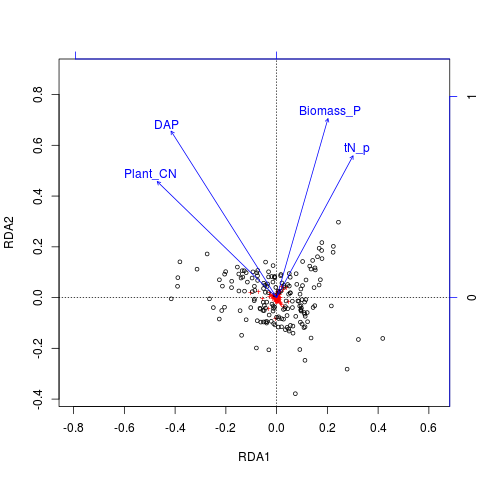

In [248]:
%%R
nmds.fit = envfit(nmds ~ DAP + Plant_CN + tN_p + Biomass_P, 
    plantsd)
sol = PP.rda
RDA.df = data.frame(MDS1 = sol$points[,1], MDS2 = sol$points[,2])
#plot(nmds)
#plot(ord.fit)
rda.fit %>% print
enz_scores = data.frame(scores(rda.fit, "vectors")) 
enz_scores$var = rownames(enz_scores)
enz_scores %>% print
plot(PP.rda)
#plot(rda.fit)

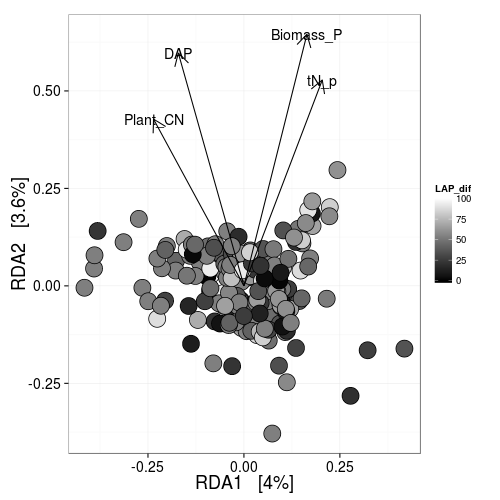

In [255]:
%%R -w 500 -h 500
p5 <- plot_ordination(physeq.plant, PP.rda, type="samples") 
p5 = p5 + geom_point(size = 8, pch = 21, aes(fill = LAP_dif)) +
        scale_fill_gradient(limits=c(0,100), low = "black", high = "white")+
    geom_segment(data=enz_scores,aes(x=0,xend = RDA1,y=0,yend=RDA2),
      arrow = arrow(length = unit(0.5, "cm")),color="black",inherit_aes=FALSE)+
        geom_text(data=enz_scores,aes(x=RDA1,y=RDA2,label=var),size=5) +
        #facet_wrap(~Maize) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18),
             strip.text = element_text(size=25))
p5


#Beta-diversity hypothesis testing on plant subset 
*Note that maize/non-maize variable should be tested too, for consistency

In [147]:
%%R
df = as(sample_data(physeq.plant), "data.frame")
d = plant.wunif.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant      21    2.1909 0.104326  7.6683 0.50625  0.001 ***
Treatment   1    0.0552 0.055205  4.0578 0.01276  0.002 ** 
Residuals 153    2.0815 0.013605         0.48099           
Total     175    4.3276                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [145]:
%%R
#Compare bray to w-unifrac
df = as(sample_data(physeq.plant), "data.frame")
d = plant.bray.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Plant      21    8.4563 0.40268  4.8872 0.39718  0.001 ***
Treatment   1    0.2281 0.22808  2.7682 0.01071  0.001 ***
Residuals 153   12.6063 0.08239         0.59210           
Total     175   21.2906                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


*Note: what OTUs are influenced by fertilization treatment?

In [124]:
%%R
plant_group = get_variable(physeq.plant, "Plant")
d = plant.wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.5934 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0229 0.0295 0.0347 0.0431 

Dissimilarity ranks between and within classes:
         0%     25%    50%      75%  100%     N
Between   1 4134.75 7936.5 11670.25 15400 14784
75-062   42  378.50  999.0  3114.50  8061    28
ABUTH    70 2466.50 6506.0 13033.50 15131    28
AMAPO    17  927.25 2764.5  5019.25 13047    28
B73     104  901.00 3708.5  9620.75 12105    28
B97      31  925.50 1528.0  4483.00  8971    28
ECHCG    22 4923.00 8179.0 12673.75 14619    28
ELCOR    38  376.25 1539.5  3906.00 10158    28
ERATE    20  723.00 2102.5  5215.25 14227    28
FAGES     2   15.50   79.0   321.25  2160    28
GLYMA   510 4319.00 8780.5 11514.50 15068    28
H99      72 1217.25 2842.5  4501.75  6104    28
HELAN    81 1004.00 1681.5  2865.75  8332    28
Hp301  

### Beta-diversity hypothesis tests on just maize

In [125]:
%%R
sample_data(physeq.plant) %>% colnames

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "BX_rel"              "CB_rel"              "LAP_rel"            
[25] "NAG_rel"             "BX_activity_g"       "CB_activity_g"      
[28] "LAP_activity_g"      "NAG_activity_g"      "BX_bare_factor"     
[31] "CB_bare_factor"      "LAP_bare_factor"     "NAG_bare_factor"    
[34] "BX_dif"              "CB_dif"              "LAP_dif"            
[37] "NAG_dif"             "Moisture"            "PO_Activity"        
[40] "PER_Activity"        "PO.barefactor"       "PER.barefactor"     
[43] "

In [64]:
%%R

physeq.maize = subset_samples(physeq.thresh, Type == "Maize")
physeq.maize
physeq.nm = subset_samples(physeq.plant, Type != "Maize")
sample_data(physeq.nm) %>% head

Sample Data:        [6 samples by 52 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample4-1.03_Npos sample4-1.03_Npos       1            1             B3
sample5-1.29_Npos sample5-1.29_Npos       1            1             B5
sample4-2.02_Nneg sample4-2.02_Nneg       1            1             C3
sample4-4.21_Nneg sample4-4.21_Nneg       1            1             G3
sample1-2.23_Nneg sample1-2.23_Nneg       1            1             C1
sample2-2.08_Nneg sample2-2.08_Nneg       1            1             C7
                  primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
sample4-1.03_Npos                  18                18         18 1.03_Npos
sample5-1.29_Npos                  34                34         34 1.29_Npos
sample4-2.02_Nneg                  19                19         19 2.02_Nneg
sample4-4.21_Nneg                  23                23         23 4.21_Nneg
sample1-2.23_Nneg                   3                 3

In [129]:
%%R
df = as(sample_data(physeq.maize), "data.frame")
d = maize.wunif.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant     10   0.54231 0.054231  4.6177 0.37126  0.001 ***
Treatment  1   0.02587 0.025874  2.2031 0.01771  0.027 *  
Residuals 76   0.89256 0.011744         0.61103           
Total     87   1.46075                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##Now on just non-maize

In [65]:
%%R
registerDoParallel(cores=28)

maize.wunif.dist = phyloseq::distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

nm.wunif.dist = phyloseq::distance(physeq.nm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [66]:
%%R -w 800 -h 350


nmds = ordinate(physeq.nm, 
                method = "NMDS", 
                distance = maize.wunif.dist)

p = plot_ordination(physeq.nm, nmds, justDF = TRUE)


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

Run 0 stress 0.1769837 
Run 1 stress 0.1973938 
Run 2 stress 0.1786067 
Run 3 stress 0.1832633 
Run 4 stress 0.4107019 
Run 5 stress 0.181634 
Run 6 stress 0.2067663 
Run 7 stress 0.1849706 
Run 8 stress 0.1819669 
Run 9 stress 0.1836379 
Run 10 stress 0.1837379 
Run 11 stress 0.1879991 
Run 12 stress 0.1825156 
Run 13 stress 0.187371 
Run 14 stress 0.2043821 
Run 15 stress 0.1885433 
Run 16 stress 0.1816385 
Run 17 stress 0.1939814 
Run 18 stress 0.1809735 
Run 19 stress 0.2125634 
Run 20 stress 0.1929645 
Error in inherits(physeq, "phyloseq") : object 'nm' not found


In [67]:
%%R
df = as(sample_data(physeq.nm), "data.frame")
d = nm.wunif.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant     10   1.48788 0.148788  9.5996 0.54981  0.001 ***
Treatment  1   0.04035 0.040355  2.6037 0.01491  0.019 *  
Residuals 76   1.17795 0.015499         0.43528           
Total     87   2.70618                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [130]:
%%R
plant_group = get_variable(physeq.maize, "Plant")
d = maize.wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.3959 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0327 0.0414 0.0536 0.0652 

Dissimilarity ranks between and within classes:
        0%     25%    50%     75% 100%    N
Between  1 1040.75 1990.5 2929.25 3828 3520
75-062  25  271.25  660.0 1649.00 3015   28
B73     72  608.50 1873.0 3308.25 3631   28
B97     19  619.25  937.5 2140.25 3196   28
H99     48  777.00 1546.0 2143.75 2593   28
Hp301   70 1126.75 1755.0 2468.00 3251   28
Il14H    7  748.50 1211.5 2418.50 3019   28
Ki3     26  256.75  898.5 1511.00 3119   28
Mo18     5  585.25  874.5 1499.00 2665   28
MS71     3   83.00  349.5  941.00 2537   28
Oh7B     6  184.50 1256.5 1846.50 2773   28
Tx303   24  232.00  397.0  638.50 2063   28



#Test correlation between enzyme activity and microbial community composition

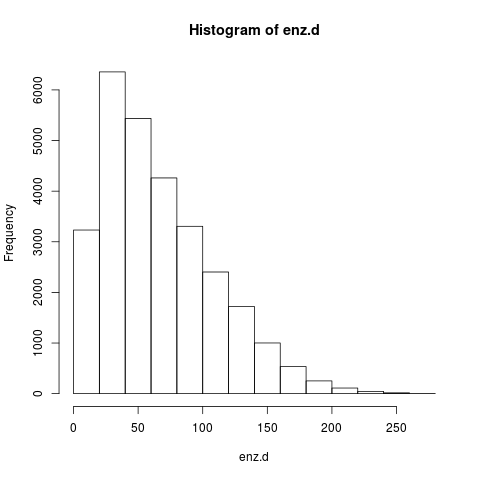

In [131]:
%%R
Sd = sample_data(physeq)
enz.d = dist(Sd[,26:29], method = "euclidian")
hist(enz.d)

In [132]:
%%R
M1 = mantel(full.wunif.dist, enz.d, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = full.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1021 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0322 0.0415 0.0476 0.0606 
Permutation: free
Number of permutations: 999



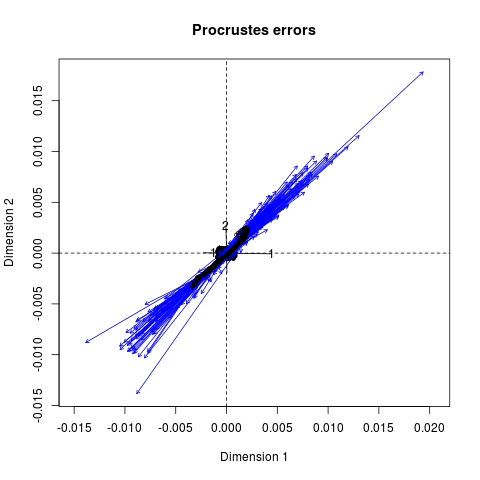

In [133]:
%%R
 p1 = protest(full.wunif.dist, enz.d, scores = "sites", permutations = 999)
plot(p1)

###Test if variation with plants is correlated with variation between plant microbial community

In [144]:
%%R
Sd = sample_data(physeq.plant)
colnames(Sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Biomass_P"           "SLA"                 "LeafC_N"            
[25] "Plant_CN"            "tN_p"                "BX_rel"             
[28] "CB_rel"              "LAP_rel"             "NAG_rel"            
[31] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[34] "NAG_activity_g"      "BX_bare_factor"      "CB_bare_factor"     
[37] "LAP_bare_factor"     "NAG_bare_factor"     "BX_dif"             
[40] "CB_dif"              "LAP_dif"             "NAG_dif"            
[43] "

In [147]:
%%R
Sd = sample_data(physeq.plant)
colnames(Sd)
EnzSD = Sd[,c(31:34)]
#enz.scale = scale(EnzSD, center = TRUE, scale = TRUE) 
enz_dist = dist(EnzSD, method = "euclidian")

$breaks
 [1]   0  20  40  60  80 100 120 140 160 180 200 220 240 260

$counts
 [1] 1849 3455 2847 2329 1765 1292  933  512  235  115   47   18    3

$density
 [1] 6.003247e-03 1.121753e-02 9.243506e-03 7.561688e-03 5.730519e-03
 [6] 4.194805e-03 3.029221e-03 1.662338e-03 7.629870e-04 3.733766e-04
[11] 1.525974e-04 5.844156e-05 9.740260e-06

$mids
 [1]  10  30  50  70  90 110 130 150 170 190 210 230 250

$xname
[1] "enz_dist"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = enz_dist, ydis = plant.wunif.dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1032 
      Significance: 0.002 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0437 0.0560 0.0685 0.0801 
Permutation: free
Number of permutations: 999



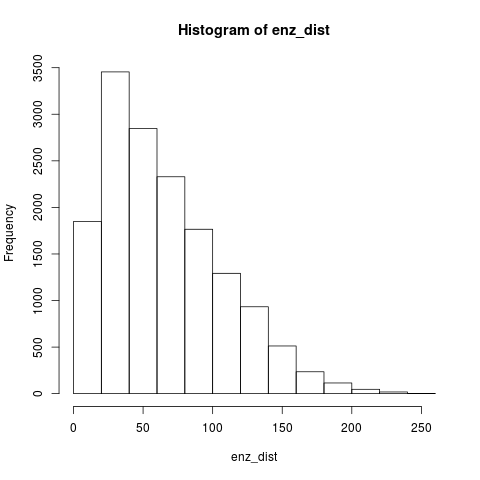

In [148]:
%%R

hist(enz_dist) %>% print

M1 = mantel(enz_dist, plant.wunif.dist, method="pearson", permutations=999)
M1 %>% print


In [149]:
%%R
Sd = sample_data(physeq.maize)
enz.d = dist(Sd[,31:34], method = "euclidian")
M1 = mantel(maize.wunif.dist, enz.d, method="pearson", permutations=999)
M1 %>% print



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = maize.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.01947 
      Significance: 0.375 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0672 0.0894 0.1071 0.1227 
Permutation: free
Number of permutations: 999



In [138]:
%%R
colnames(sample_data(plant.T50))

There were 11 warnings (use warnings() to see them)
Error in colnames(sample_data(plant.T50)) : 
  error in evaluating the argument 'x' in selecting a method for function 'colnames': Error in sample_data(plant.T50) : 
  error in evaluating the argument 'object' in selecting a method for function 'sample_data': Error: object 'plant.T50' not found


*Notes: once we are comparing among plants the microbial community is a predictor of enzyme activity, but not the rhizosphere effect on enzyme activity.  

Among maize inbred lines there the microbial community is not significant. 

Consider how to compare log2Fold change to change in enzyme activity



In [139]:
%%R
veganotu = function(physeq) {
    require("vegan")
    OTU = otu_table(physeq)
    if (taxa_are_rows(OTU)) {
        OTU = t(OTU)
    }
    return(as(OTU, "matrix"))
}

In [140]:
%%R
#Redundancy analysis between enzyme and microbial community
#1) subset microbial community to top 50 OTUs in plant treatment
plant.T50 = prune_taxa(names(sort(taxa_sums(physeq.thresh),TRUE)[1:50]), physeq.thresh)
#tax_table(plant.T50)
colnames(sample_data(plant.T50))
#2) run on non-transformed enzyme bare factors
R1 = rda(sample_data(plant.T50)[,34:37], veganotu(plant.T50), scale=TRUE)
plot(R1)
ord.fit = envfit(R1)
plot(ord.fit)

Error in complete.cases(env) : argument "env" is missing, with no default
In addition: Warning message:
In as.matrix.data.frame(X) :
  Setting class(x) to NULL;   result will no longer be an S4 object
Error in complete.cases(env) : argument "env" is missing, with no default
